In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from analyze_aparent_designed_mpra_helpers import *


<h2>Load collapsed designed MPRA data</h2>

In [2]:
#Load designed MPRA data (Collapsed over experiment replicates)
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
print("n = " + str(len(seq_dict['array_df'])))
print('Avg read count (avg over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['mean_total_count'])))
print('Pooled read count (pooled over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['pooled_total_count'])))

#Load variant dataframe
variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df, variant_df = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'])


n = 39833
Avg read count (avg over barcodes) = 431.92676310713546
Pooled read count (pooled over barcodes) = 3656.5562880452626
n (variants) = 21734


<h2>Summary SeqProp Target/Max analysis</h2>

In [4]:
#Filter data and use native human wt PASs for reference comparison
seq_df_filtered = seq_df.query("mean_total_count >= 100 and n_barcodes >= 5")

df_all = seq_df_filtered.query("experiment == 'clinvar_wt' and variant == 'wt'")
max_iso_df_all = seq_df_filtered.query("experiment == 'max_iso' and variant != 'snv'")
max_iso_df_all = max_iso_df_all.loc[max_iso_df_all.subexperiment.str.contains('max_score')]
max_iso_df_all = max_iso_df_all.loc[~max_iso_df_all.subexperiment.str.contains('cstf')]


pred_column = 'logodds_pred'
true_column = 'median_proximal_vs_distal_logodds'

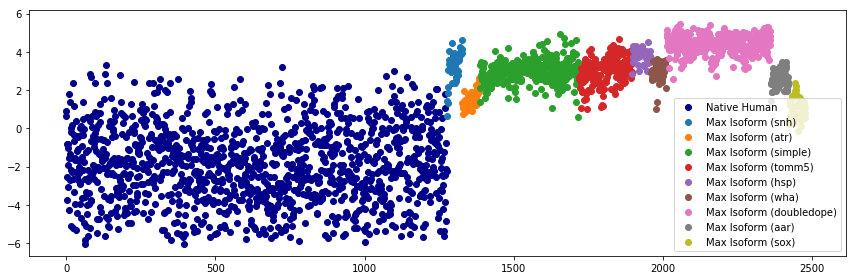

In [5]:
#Strip plot of measured isoform log odds distributions per optimized library
f = plt.figure(figsize=(12, 4))

plt.scatter(np.arange(len(df_all)), df_all[true_column], c='darkblue', label='Native Human')

n_points = len(df_all)

for gene in max_iso_df_all['gene'].unique() :
    max_iso_df_gene = max_iso_df_all.query("gene == '" + gene + "'")
    plt.scatter(np.arange(len(max_iso_df_gene)) + n_points, max_iso_df_gene[true_column], label='Max Isoform (' + gene + ')')

    n_points += len(max_iso_df_gene)
    
plt.legend()

plt.tight_layout()
plt.show()

Total # of Max Isoform/Target ratio sequences = 1466
# of target_00 sequences = 53
# of target_025 sequences = 48
# of target_05 sequences = 55
# of target_075 sequences = 54
# of target_10 sequences = 54
# of max_score sequences = 1202


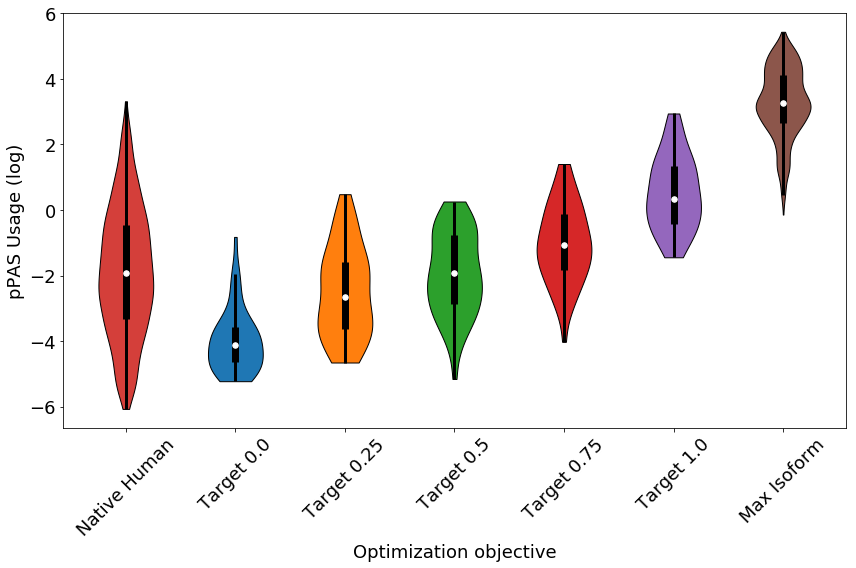

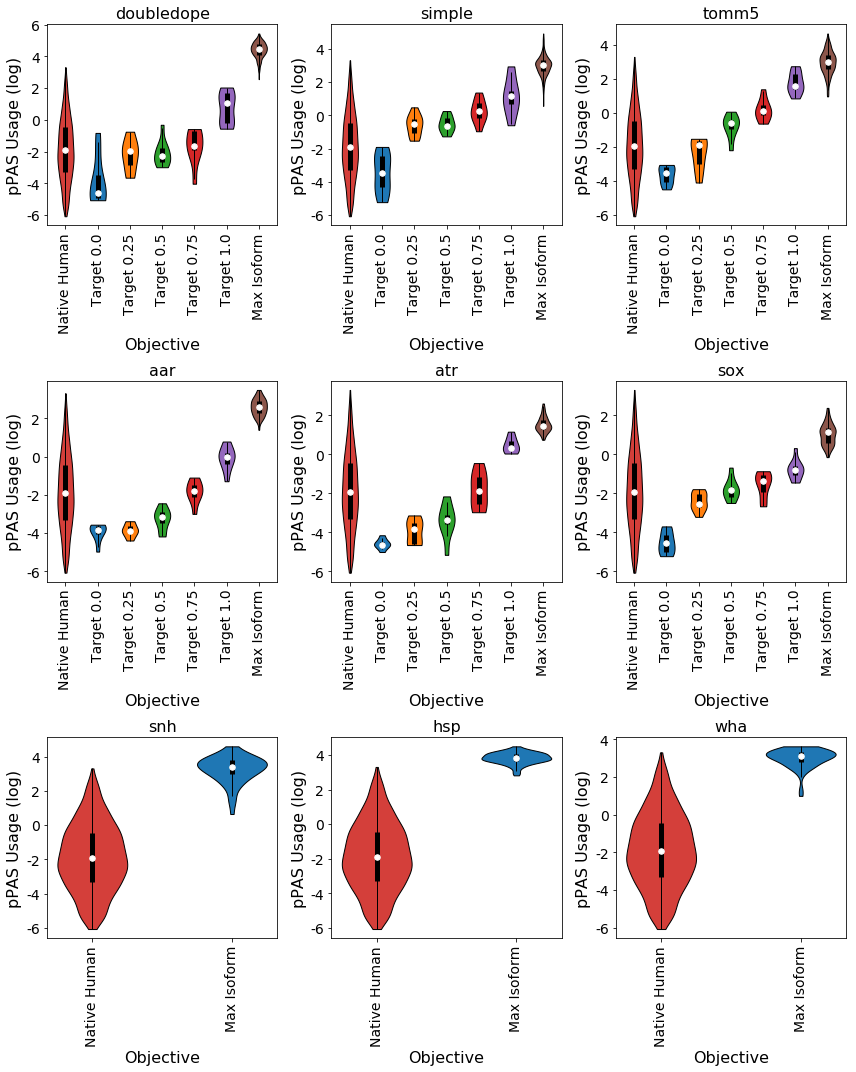

In [6]:
#Violin plot of target isoform- optimized sequences
save_figs = False
show_axis = True

max_iso_df_all = seq_df_filtered.query("experiment == 'max_iso' and variant != 'snv'")
max_iso_df_all = max_iso_df_all.loc[~max_iso_df_all.subexperiment.str.contains('cstf')]

violindata = [
    sorted(np.array(np.ravel(df_all[true_column].values)))
]

violinlabels = [
    'Native Human'
]

included_genes = [
    'doubledope',
    'simple',
    'tomm5',
    'aar',
    'atr',
    'sox',
    'snh',
    'hsp',
    'wha'
]

subexps = [
    ['target_00', 'Target 0.0'],
    ['target_025', 'Target 0.25'],
    ['target_05', 'Target 0.5'],
    ['target_075', 'Target 0.75'],
    ['target_10', 'Target 1.0'],
    ['max_score', 'Max Isoform'],
]

print("Total # of Max Isoform/Target ratio sequences = " + str(len(max_iso_df_all)))

for subexp, iso_label in subexps :
    
    violinlabels.append(iso_label)
    curr_data = sorted(np.array(np.ravel(max_iso_df_all.loc[max_iso_df_all.subexperiment.str.contains(subexp)][true_column].values)))
    
    print("# of " + subexp + " sequences = " + str(len(curr_data)))
    
    violindata.append(curr_data)


if show_axis :
    f = plt.figure(figsize=(12, 8))
else :
    f = plt.figure(figsize=(6, 4))

parts = plt.violinplot(violindata, np.arange(len(violindata)), showmeans=False, showextrema=False, showmedians=False)

violin_colors = ['#D43F3A', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
for i, pc in enumerate(parts['bodies']):
    #pc.set_facecolor('#D43F3A')
    pc.set_facecolor(violin_colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1)


def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


percs = [np.percentile(violindata[i], [25, 50, 75], axis=0) for i in range(0, len(violindata))]
quartile1, medians, quartile3 = zip(*percs)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(violindata, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]


inds = np.arange(len(violindata))
plt.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=7)
plt.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=3)

if show_axis :
    plt.xticks(np.arange(len(violindata)), violinlabels, rotation=45, fontsize=18)
    plt.yticks(fontsize=18)

    plt.xlabel('Optimization objective', fontsize=18)
    plt.ylabel('pPAS Usage (log)', fontsize=18)
else :
    plt.xticks([], [])
    plt.yticks([], [])

plt.tight_layout()
if save_figs :
    plt.savefig('max_isoform_violin_all.png', transparent=True, dpi=150)
    plt.savefig('max_isoform_violin_all.svg')
    plt.savefig('max_isoform_violin_all.eps')
plt.show()


#Break down target isoform- analysis by library
if show_axis :
    f, ax = plt.subplots(3, 3, figsize=(12, 15))
else :
    f, ax = plt.subplots(3, 3, figsize=(8, 8))

for gene_i, gene in enumerate(included_genes) :
    violindata = [
        sorted(np.ravel(df_all[true_column].values))
    ]

    violinlabels = [
        'Native Human'
    ]

    row_i = int(gene_i / 3)
    col_i = int(gene_i % 3)

    for subexp, iso_label in subexps :
        curr_data = np.ravel(max_iso_df_all.query("gene == '" + gene + "'").loc[max_iso_df_all.subexperiment.str.contains(subexp)][true_column].values)
        
        if len(curr_data) > 0 :
            violinlabels.append(iso_label)
            violindata.append(sorted(curr_data))


    #ax[row_i, col_i].violinplot(violindata, np.arange(len(violindata)), points=60, widths=0.7, showmeans=True, showextrema=True, showmedians=True, bw_method=0.5)
    parts = ax[row_i, col_i].violinplot(violindata, np.arange(len(violindata)), showmeans=False, showextrema=False, showmedians=False)

    violin_colors = ['#D43F3A', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    for i, pc in enumerate(parts['bodies']):
        #pc.set_facecolor('#D43F3A')
        pc.set_facecolor(violin_colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    percs = [np.percentile(violindata[i], [25, 50, 75], axis=0) for i in range(0, len(violindata))]
    quartile1, medians, quartile3 = zip(*percs)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(violindata, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

    plt.sca(ax[row_i, col_i])

    inds = np.arange(len(violindata))
    plt.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    plt.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

    if show_axis :
        plt.xticks(np.arange(len(violindata)), violinlabels, rotation=90, fontsize=14)
        plt.yticks(fontsize=14)

        #ax[row_i, col_i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax[row_i, col_i].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

        plt.title(gene, fontsize=16)
        plt.xlabel('Objective', fontsize=16)
        plt.ylabel('pPAS Usage (log)', fontsize=16)
    else :
        plt.xticks([], [])
        plt.yticks([], [])


plt.tight_layout()
if save_figs :
    plt.savefig('max_isoform_violin_per_library.png', transparent=True, dpi=150)
    plt.savefig('max_isoform_violin_per_library.svg')
    plt.savefig('max_isoform_violin_per_library.eps')
plt.show()

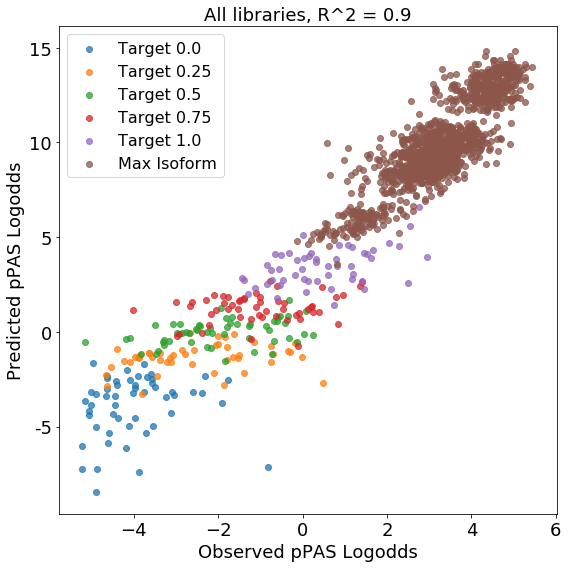

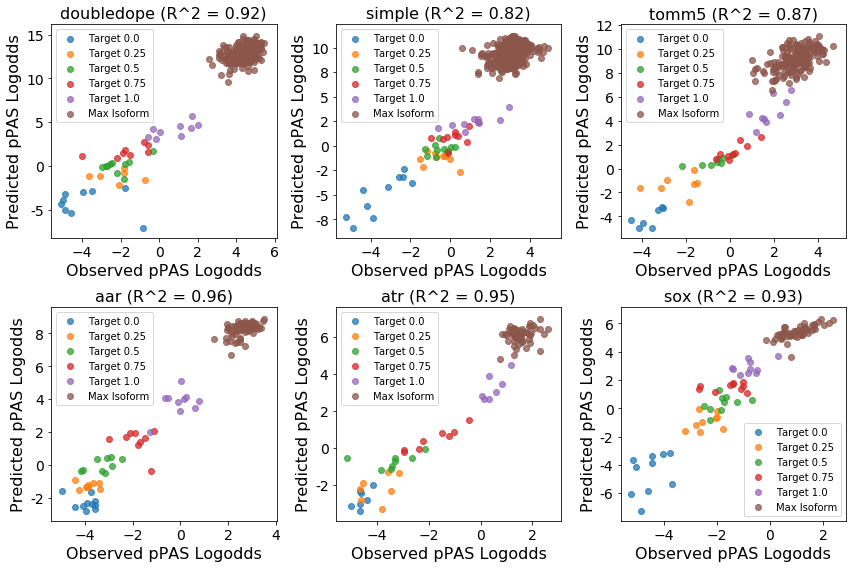

In [7]:
#Scatter plot of predicted vs. measured log odds of target isoform- sequences
r_val, _ = pearsonr(max_iso_df_all[true_column], max_iso_df_all[pred_column])

if show_axis :
    f = plt.figure(figsize=(8, 8))
else :
    f = plt.figure(figsize=(4, 4))

for subexp, subexp_label in subexps :
    max_iso_sub = max_iso_df_all.loc[max_iso_df_all.subexperiment.str.contains(subexp)]
    plt.scatter(max_iso_sub[true_column], max_iso_sub[pred_column], alpha=0.75, label=subexp_label)

if show_axis :
    plt.title('All libraries, R^2 = ' + str(round(r_val * r_val, 2)), fontsize=18)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    ax = plt.gca()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    plt.xlabel('Observed pPAS Logodds', fontsize=18)
    plt.ylabel('Predicted pPAS Logodds', fontsize=18)

    plt.legend(fontsize=16)
else :
    plt.xticks([], [])
    plt.yticks([], [])

plt.tight_layout()
if save_figs :
    plt.savefig('max_isoform_scatter_all.png', transparent=True, dpi=150)
    plt.savefig('max_isoform_scatter_all.eps')
plt.show()




#Break down by library
if show_axis :
    f, ax = plt.subplots(2, 3, figsize=(12, 8))
else :
    f, ax = plt.subplots(2, 3, figsize=(8, 8./3. * 2.))

included_genes = [
    'doubledope',
    'simple',
    'tomm5',
    'aar',
    'atr',
    'sox'
]

for gene_i, gene in enumerate(included_genes) :
    
    row_i = int(gene_i / 3)
    col_i = int(gene_i % 3)

    r_val, _ = pearsonr(max_iso_df_all.query("gene == '" + gene + "'")[true_column], max_iso_df_all.query("gene == '" + gene + "'")[pred_column])
    
    for subexp, iso_label in subexps :
        curr_data = max_iso_df_all.query("gene == '" + gene + "'").loc[max_iso_df_all.subexperiment.str.contains(subexp)]
        
        if len(curr_data) > 0 :
            ax[row_i, col_i].scatter(curr_data[true_column], curr_data[pred_column], alpha=0.75, label=iso_label)

    plt.sca(ax[row_i, col_i])
    
    if show_axis :
        plt.title(gene + ' (R^2 = ' + str(round(r_val * r_val, 2)) + ')', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        ax[row_i, col_i].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

        plt.xlabel('Observed pPAS Logodds', fontsize=16)
        plt.ylabel('Predicted pPAS Logodds', fontsize=16)
        plt.legend()
    else :
        plt.xticks([], [])
        plt.yticks([], [])


plt.tight_layout()
if save_figs :
    plt.savefig('max_isoform_scatter_per_library.png', transparent=True, dpi=150)
    plt.savefig('max_isoform_scatter_per_library.eps')
plt.show()